In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers - np.average(any_numbers)) / np.std(any_numbers)

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fit(t, x, y):
    """The fitted values along the regression line."""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b

def plot_residuals(t, x, y):
    """Plot a scatter diagram and residuals."""
    t.scatter(x, y, fit_line=True)
    actual = t.column(y)
    fitted = fit(t, x, y)
    residuals = actual - fitted
    print('r:', correlation(t, x, y))
    print('RMSE:', np.mean(residuals**2)**0.5)
    t.select(x).with_column('Residual', residuals).scatter(0, 1)

# Regression Model

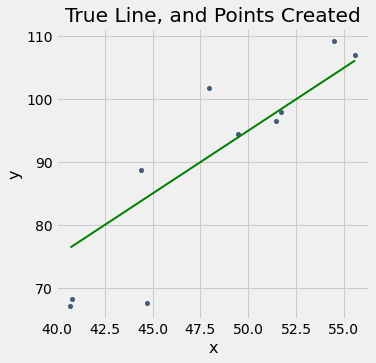

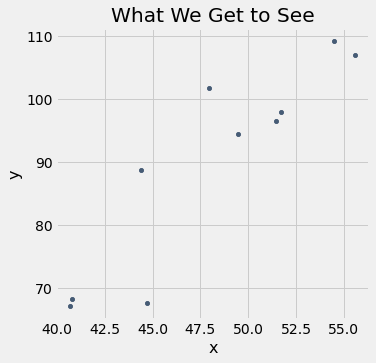

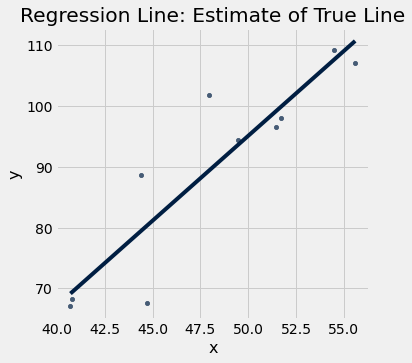

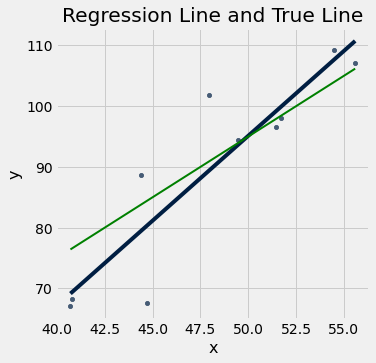

In [4]:
def draw_and_compare(true_slope, true_int, sample_size):
    """ Given true_slope and true_intercept, 
        randomly create sample_size-number
        of points along the line 
        (where we add some noise to the y-value)
    
    """
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)
    
    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')
    
    sample.scatter('x', 'y')
    plots.title('What We Get to See')
    
    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')
    
    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('Regression Line and True Line')
    
draw_and_compare(2, -5, 10)

**Question:** Were the regression line and the true line the same?

let's draw the same but for 100 and then 1000 examples

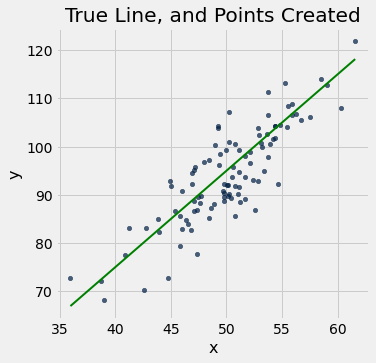

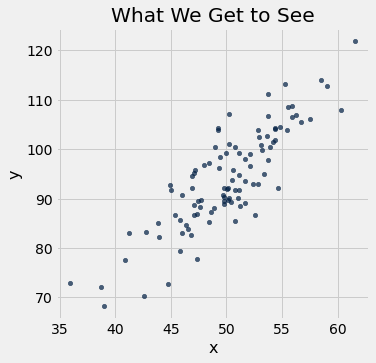

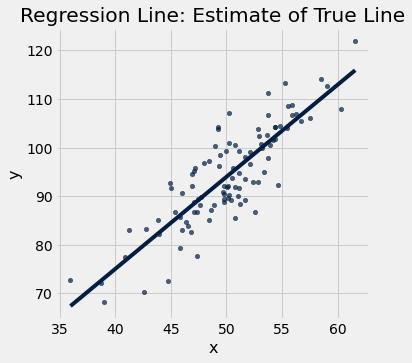

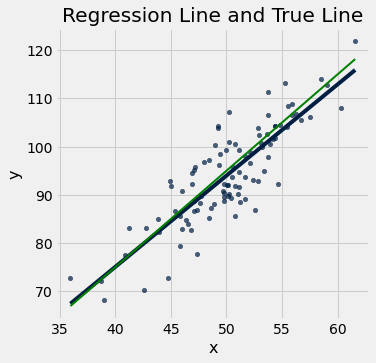

In [5]:
draw_and_compare(2, -5, 100)

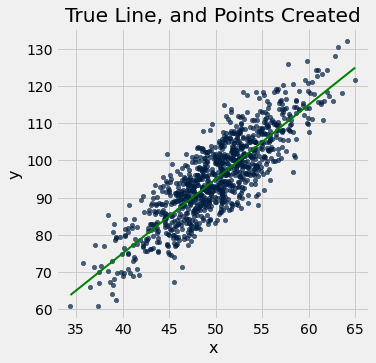

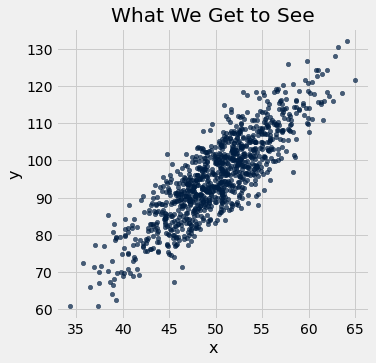

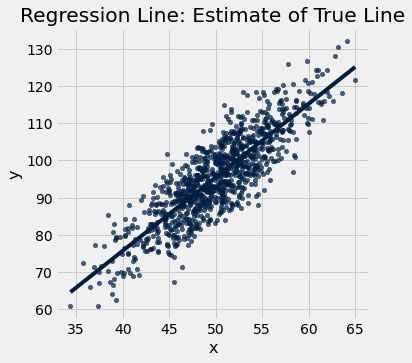

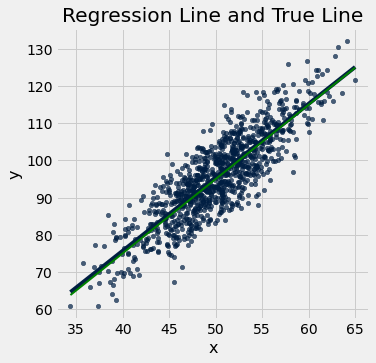

In [6]:
draw_and_compare(2, -5, 1000)

**True or False Question:** The more points we have, the further away the regression line will be from the True line?

# Prediction Variability


In [7]:
baby = Table.read_table('baby.csv')
baby.show(5)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False


**Question:** Is there a linear assocation between the length of a pregnancy and the birth weight?

Visualize, then quantify!

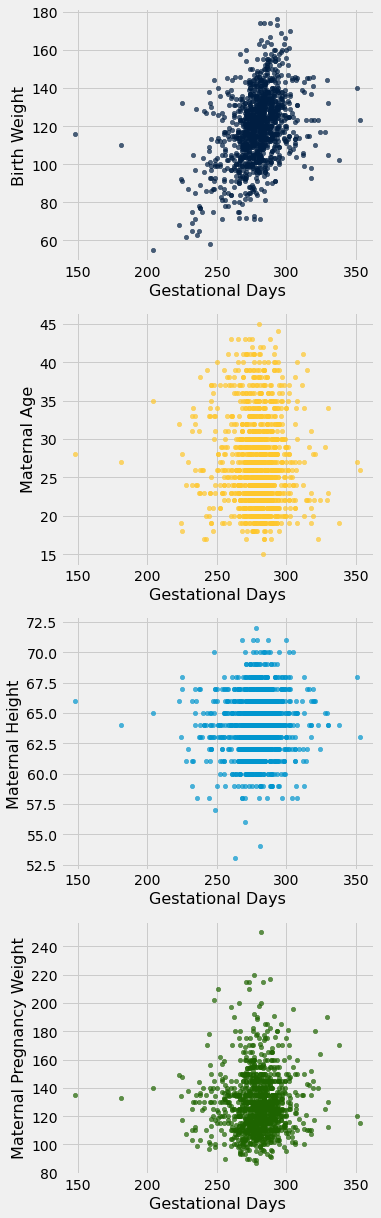

In [12]:
baby.drop('Maternal Smoker').scatter('Gestational Days', overlay=False)

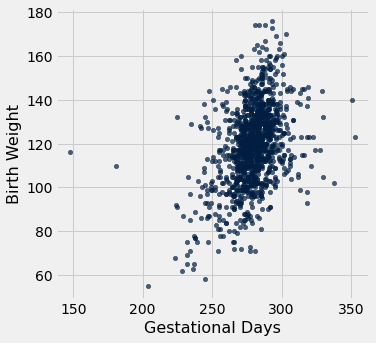

In [13]:
baby.select(0, 1).scatter('Gestational Days')

In [15]:
correlation(baby, 1, 0)

0.4075427933888511

Let's look at the error of our predictions.

**Question:** How can we do that?

r: 0.4075427933888511
RMSE: 16.730358256655432


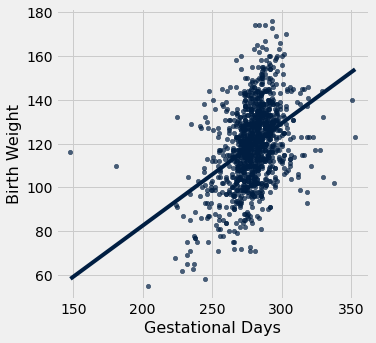

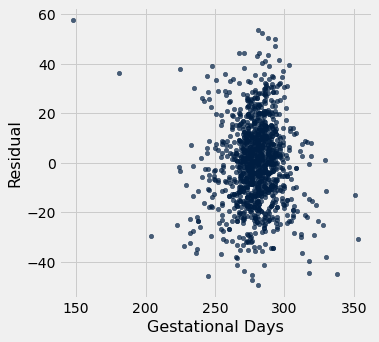

In [17]:
plot_residuals(baby, 1, 0)

There is not much structure in the residual (it is a blob) so that means this is a fairly linear association

Let's focus on the middle of the residuals and pick 300 as an x-value

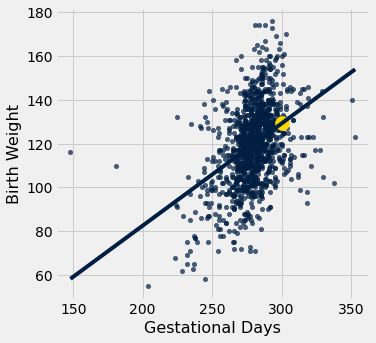

In [18]:
x = 300
a = slope(baby, 'Gestational Days', 'Birth Weight')
b = intercept(baby, 'Gestational Days', 'Birth Weight')
predicted_y = a * x + b
baby.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.scatter(300, predicted_y, color='gold', s=200);

When `x=300`, the predicted y is ...

In [19]:
predicted_y

129.2129241703143

We found this by using the prediction function. 

In [20]:
def prediction_at(t, x):
    a = slope(t, 'Gestational Days', 'Birth Weight')
    b = intercept(t, 'Gestational Days', 'Birth Weight')
    return a * x + b


We can make a prediction for a new sample of our data

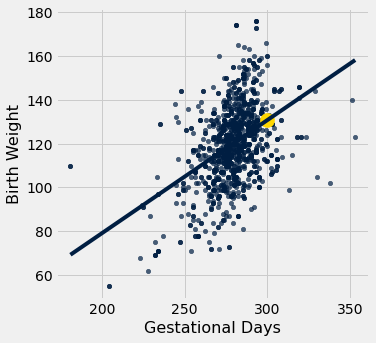

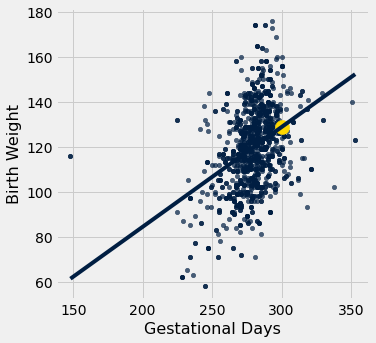

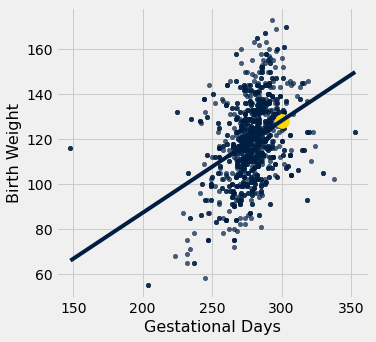

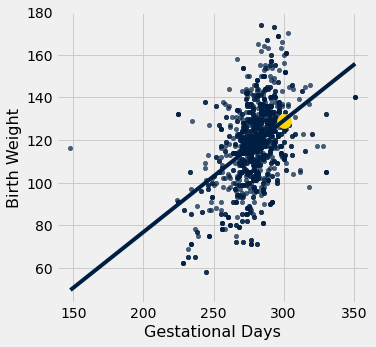

In [25]:
for i in np.arange(4):
    resample = baby.sample()
    predicted_y = prediction_at(resample, 300)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=200)

**Question:** Is there variation in our predicted y-value when `x==300`?

Let's draw 10 different regression lines based on 10 resamples

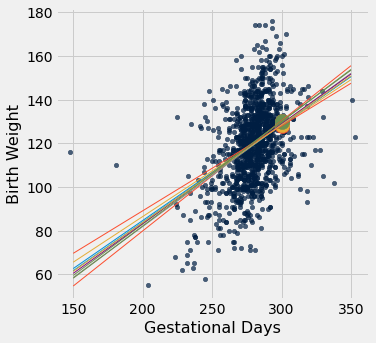

In [26]:
lines = Table(['slope', 'intercept', 'at 150', 'at 300', 'at 350'])

for i in range(10):
    resample = baby.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 150 + b, a * 300 + b, a * 350 + b])
    
baby.scatter('Gestational Days', 'Birth Weight')
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([150, 350], [line.item('at 150'), line.item('at 350')], lw=1)
    plots.scatter(300, line.item('at 300'), s=200)

**Question:** Where do we get very different regressions (estimated y-values)?

Let's repeat this but zoom in on `x==300`

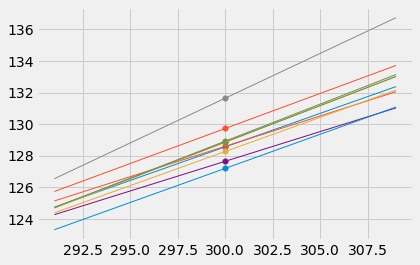

In [27]:
lines = Table(['slope', 'intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = baby.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])
    
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30)

**Question:** What is the kind of variability we see in this zoomed in figure?

Now we can compute the bootstrap to compute Confidence Interval

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
Approximate 95%-confidence interval for height of true line:
127.2760277988826 131.28567616187178 (width = 4.009648362989182 )


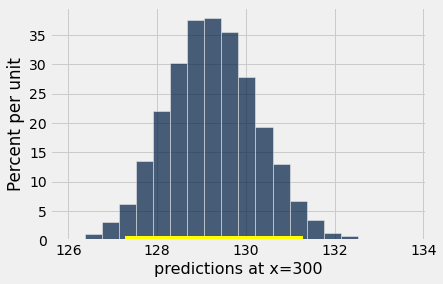

In [29]:
# This will take about 15 seconds so let's walk through the code

%time
def bootstrap_prediction(table, x, y, new_x, repetitions=5000):

    # Bootstrap resampling
    predictions = make_array()                    # set up our array of empty predictions
    for i in np.arange(repetitions):      # repeat this "repetitions"-amount of times
        resample = table.sample(with_replacement=True)         # take our resample
        a = slope(resample, x, y)        # find the slope of regression-line, aka 'best-fit line', in our resample
        b = intercept(resample, x, y)    # find the interecept of regression-lione based on our sample
        predicted_y = a * new_x + b       # predict a new y 
        predictions = np.append(predictions, predicted_y)   # add the predicted y to our predictions

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')')
    
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 300)

**Question:** What happens to our confidence interval if we want to make a prediction further from the center, so say `x==330`?

Approximate 95%-confidence interval for height of true line:
138.72116862951384 147.798171461758 (width = 9.077002832244148 )


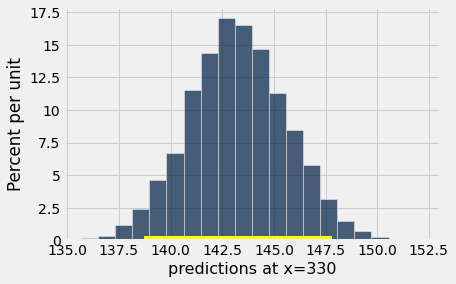

In [30]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 330)

**Question:** What happens to our confidence interval if we want to make a prediction closer to the center, so say `x==270`?

Approximate 95%-confidence interval for height of true line:
113.87542549445853 116.49560402170825 (width = 2.6201785272497204 )


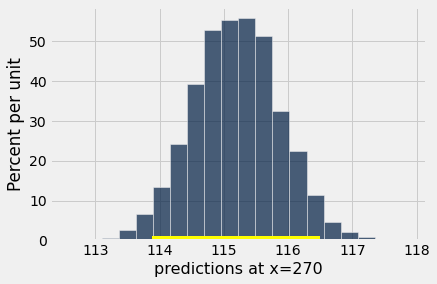

In [31]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 270)

# Slope Inference

**Question:** How do we find the slope of 'Gestational Days', 'Birth Weight'?

In [32]:
slope(baby, 'Gestational Days', 'Birth Weight')

0.4665568769492152

This value is different than *r*. 

**Question:** why is that the case?

In [33]:
correlation(baby, 'Gestational Days', 'Birth Weight')

0.4075427933888511

Let's take 4 samples and see what the slope is each time

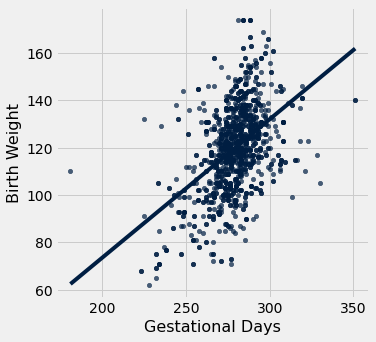

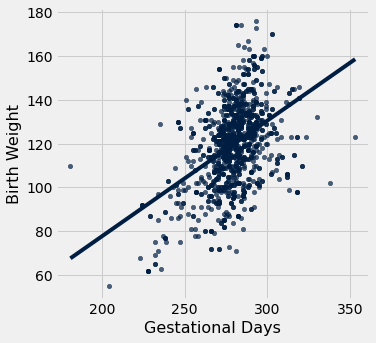

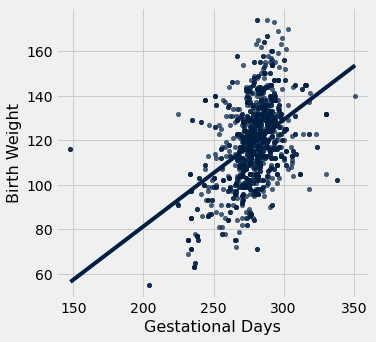

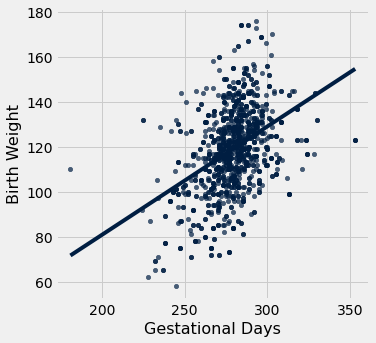

In [34]:
for i in np.arange(4):
    baby.sample().scatter('Gestational Days', 'Birth Weight', fit_line=True)

**Question:** Do the slopes look similar?

*Hint: It is easier to determine this by looking at the ends of the line* 

Let's show these lines together in one graph

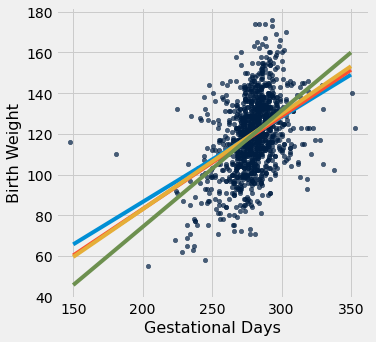

In [35]:
baby.scatter('Gestational Days', 'Birth Weight')
for i in np.arange(4):
    resample = baby.sample()
    s = slope(resample, 'Gestational Days', 'Birth Weight')
    c = intercept(resample, 'Gestational Days', 'Birth Weight')
    xlims = make_array(150, 350)
    plots.plot(xlims, s*xlims + c, lw=4)

Let's do this 5k times

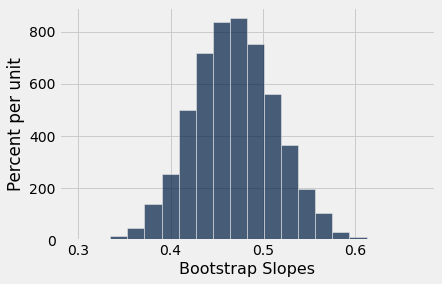

In [36]:
slopes = []
for i in np.arange(5000):
    resample = baby.sample()
    resample_slope = slope(resample, 'Gestational Days', 'Birth Weight')
    slopes.append(resample_slope)
Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)

**Question:** How can we find confidence intervals of the estimated slope?

In [37]:
left = percentile(2.5 ,slopes)
right = percentile(97.5 ,slopes)
[left, right]

[0.38156734422456035, 0.5585573438054027]

Slope of regression line: 0.4665568769492152
Approximate 95%-confidence interval for the true slope:
0.3838006658162632 0.5561971652174753


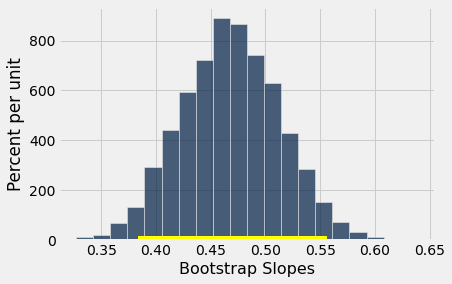

In [38]:
def bootstrap_slope(table, x, y, repetitions=5000):
    
    # Bootstrap resampling
    slopes = []
    for i in np.arange(repetitions):
        resample = table.sample()
        resample_slope = slope(resample, x, y)
        slopes.append(resample_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)
    
bootstrap_slope(baby, 1, 0)

In [42]:
baby.labels

('Birth Weight',
 'Gestational Days',
 'Maternal Age',
 'Maternal Height',
 'Maternal Pregnancy Weight',
 'Maternal Smoker')

r: -0.053424773507798104
RMSE: 15.980630030890573


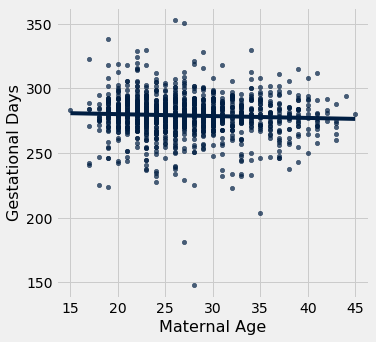

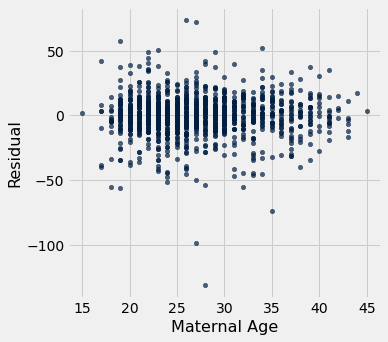

In [39]:
plot_residuals(baby, 2, 1)

Slope of regression line: -0.14702142270280957
Approximate 95%-confidence interval for the true slope:
-0.3015398589954061 0.010123482753168347


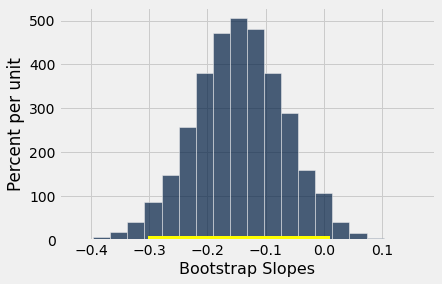

In [40]:
bootstrap_slope(baby, 2, 1)

**Question:** How do we know there was actually a slope and that the variability wasn't caused by an error?

(slides for answer)

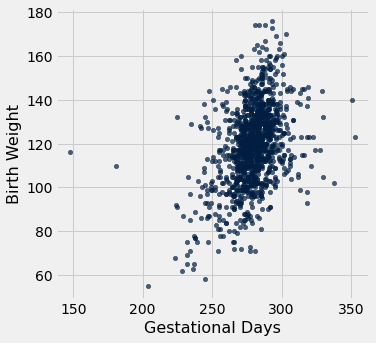

In [41]:
 baby.scatter('Gestational Days', 'Birth Weight')

In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook()
grader.export("Lecture_22_completed.ipynb", pdf=False)